*** ARMIA Model***


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm 


In [2]:

# Fetch Sage PLC data
tickerSymbol = 'SGE.L'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start='2013-01-01', end='2024-01-01')


$SGE.L: possibly delisted; no price data found  (1d 2013-01-01 -> 2024-01-01)


In [3]:
# Display the first few rows of the data
print(tickerDf.head())
# Find and print the feature names (column headers)
print("Feature names (columns) in the dataset:")
print(tickerDf.columns)


Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
Feature names (columns) in the dataset:
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [6]:

# Fetch FTSE 100 data
ftse_data = yf.download("^FTSE", start="2013-01-01", end="2024-01-01")
print(ftse_data.head())


[*********************100%***********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2013-01-02  5897.799805  6044.600098  5897.799805  6027.399902  6027.399902   
2013-01-03  6027.399902  6051.299805  6016.799805  6047.299805  6047.299805   
2013-01-04  6047.299805  6089.799805  6038.000000  6089.799805  6089.799805   
2013-01-07  6089.799805  6091.500000  6060.799805  6064.600098  6064.600098   
2013-01-08  6064.600098  6088.200195  6053.600098  6053.600098  6053.600098   

               Volume  
Date                   
2013-01-02  652659400  
2013-01-03  470665900  
2013-01-04  548929200  
2013-01-07  571661700  
2013-01-08  663115700  


In [7]:

# Step 1: Convert both DateTime indexes to timezone-naive (remove timezone info)
tickerDf.index = tickerDf.index.tz_localize(None)
ftse_data.index = ftse_data.index.tz_localize(None)

In [18]:
# Step 2: Align datasets on date (use outer join to preserve all data points)
tickerDf = tickerDf.merge(ftse_data[['Close']], how='outer', left_index=True, right_index=True, suffixes=('', '_FTSE'))
tickerDf.rename(columns={'Close_FTSE': 'FTSE_Close'}, inplace=True)

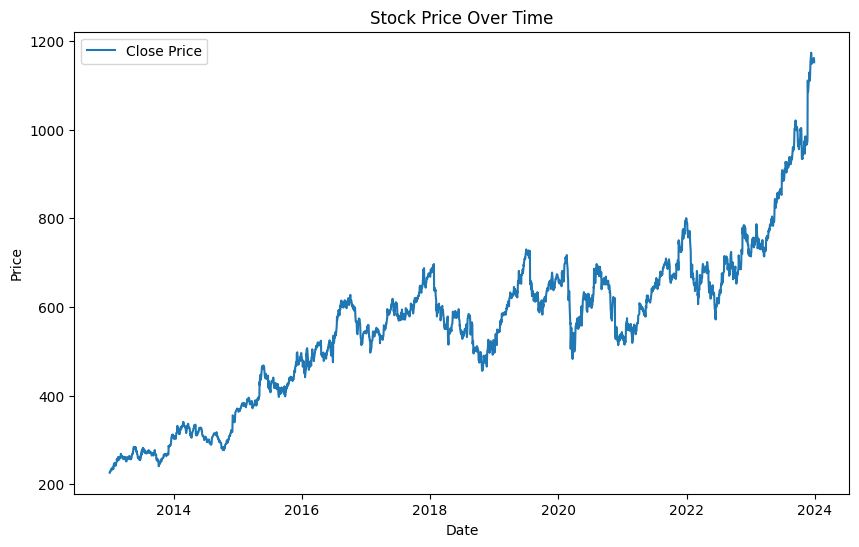

In [9]:
    # Step 2: Plotting stock price trends
    plt.figure(figsize=(10, 6))
    plt.plot(tickerDf['Close'], label='Close Price')
    plt.title('Stock Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

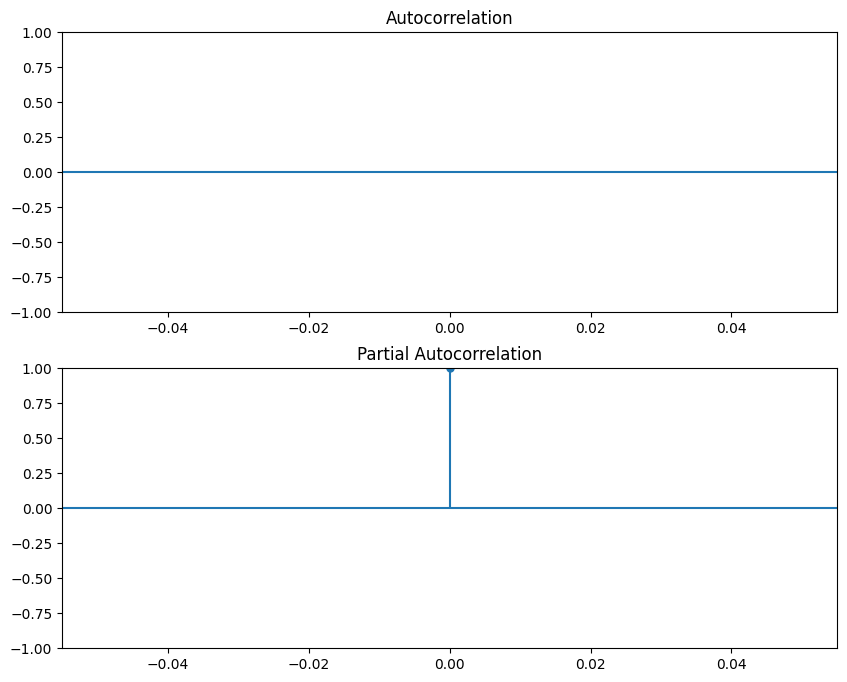

In [10]:
# Importing the necessary statsmodels module
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 4: ACF and PACF Plots
fig, ax = plt.subplots(2, figsize=(10, 8))

# Plotting the Autocorrelation Function (ACF)
sm.graphics.tsa.plot_acf(tickerDf['Close'], lags=40, ax=ax[0])

# Plotting the Partial Autocorrelation Function (PACF)
sm.graphics.tsa.plot_pacf(tickerDf['Close'], lags=40, ax=ax[1])

# Show the plots
plt.show()


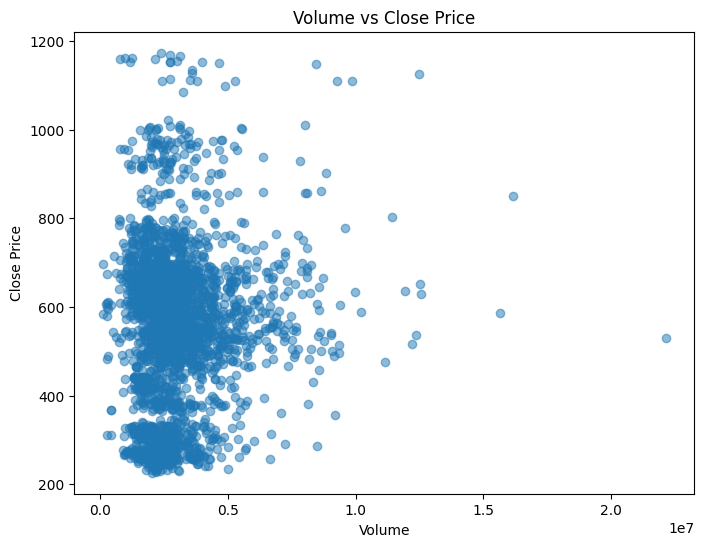

In [12]:
# Step 5: Scatter plot (e.g., Volume vs Close price)
plt.figure(figsize=(8, 6))
plt.scatter(tickerDf['Volume'], tickerDf['Close'], alpha=0.5)
plt.title('Volume vs Close Price')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.show()

In [13]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Sample text data for sentiment analysis
text_data = [
    "Sage stocks are performing well",
    "There are concerns about market volatility for Sage PLC",
    "Sage has reported a strong quarterly earnings",
    "Uncertainty around the global economy is rising which is affecting sage",
    "New innovations from Sage are driving stock growth"
]

# Adjust the length of the text data to match the length of tickerDf
tickerDf['Text'] = (text_data * (len(tickerDf) // len(text_data) + 1))[:len(tickerDf)]

# Create a new column 'Sentiment_MA' based on VADER sentiment scores
tickerDf['Sentiment_MA'] = tickerDf['Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Print the first 5 rows of the sentiment scores
print(tickerDf[['Text', 'Sentiment_MA']].head())


                                                         Text  Sentiment_MA
Date                                                                       
2013-01-02                    Sage stocks are performing well        0.2732
2013-01-03  There are concerns about market volatility for...        0.0000
2013-01-04      Sage has reported a strong quarterly earnings        0.5106
2013-01-07  Uncertainty around the global economy is risin...       -0.3400
2013-01-08  New innovations from Sage are driving stock gr...        0.3818


In [14]:
# Step 4: Handle missing values (interpolate and fill)
tickerDf['FTSE_Close'] = tickerDf['FTSE_Close'].interpolate(method='linear')
tickerDf['FTSE_Close'] = tickerDf['FTSE_Close'].fillna(method='ffill')
tickerDf['Close'] = tickerDf['Close'].fillna(method='ffill')  # Fill any missing values in the target 'Close' column

# Check if any NaN values remain
print("NaN values after alignment and filling:")
print(tickerDf.isna().sum())

NaN values after alignment and filling:
Open            1
High            1
Low             1
Close           0
Volume          1
Dividends       1
Stock Splits    1
FTSE_Close      0
Text            0
Sentiment_MA    0
dtype: int64


/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_2230/4225069643.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tickerDf['FTSE_Close'] = tickerDf['FTSE_Close'].fillna(method='ffill')
/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_2230/4225069643.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tickerDf['Close'] = tickerDf['Close'].fillna(method='ffill')  # Fill any missing values in the target 'Close' column


In [15]:
# Step 5: Split into train and test sets
train_size = int(len(tickerDf) * 0.8)
train = tickerDf.iloc[:train_size]
test = tickerDf.iloc[train_size:]

# Final check for NaN values before model training
print("NaN values in train set:")
print(train.isna().sum())
print("NaN values in test set:")
print(test.isna().sum())

NaN values in train set:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
FTSE_Close      0
Text            0
Sentiment_MA    0
dtype: int64
NaN values in test set:
Open            1
High            1
Low             1
Close           0
Volume          1
Dividends       1
Stock Splits    1
FTSE_Close      0
Text            0
Sentiment_MA    0
dtype: int64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWar

ARIMA Model Performance:
RMSE: 117.8757
MAE: 81.4568
MAPE: nan%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_2230/2943891275.py:15: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  arima_mape = np.mean(np.abs((test['Close'] - arima_forecast) / test['Close'])) * 100


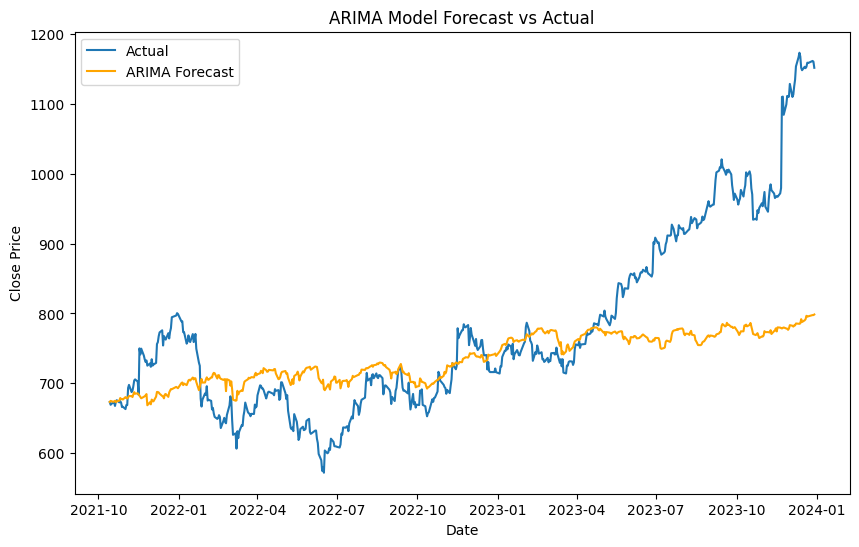

In [16]:
# Step 6: Ensure that the datasets are non-empty before fitting the model
if not train.empty and not test.empty:
    # Step 7: Fit the ARIMA model using the training set
    arima_model = ARIMA(train['Close'], order=(2, 2, 2), exog=train[['FTSE_Close', 'Sentiment_MA']])
    arima_model_fit = arima_model.fit()

    # Step 8: Make predictions on the test set
    arima_forecast = arima_model_fit.forecast(steps=len(test), exog=test[['FTSE_Close', 'Sentiment_MA']])

    # Step 9: Final check for NaN values before evaluation
    if not test['Close'].isna().any() and not pd.isna(arima_forecast).any():
        # Step 10: Evaluate the model's performance
        arima_rmse = np.sqrt(mean_squared_error(test['Close'], arima_forecast))
        arima_mae = mean_absolute_error(test['Close'], arima_forecast)
        arima_mape = np.mean(np.abs((test['Close'] - arima_forecast) / test['Close'])) * 100

        # Print evaluation metrics
        print("ARIMA Model Performance:")
        print(f"RMSE: {arima_rmse:.4f}")
        print(f"MAE: {arima_mae:.4f}")
        print(f"MAPE: {arima_mape:.2f}%")

        # Step 11: Plot actual vs forecasted values
        plt.figure(figsize=(10, 6))
        plt.plot(test.index, test['Close'], label='Actual')
        plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange')
        plt.title('ARIMA Model Forecast vs Actual')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()
    else:
        print("Error: NaN values found in the forecast or test set.")
else:
    print("Error: Train or Test dataset is still empty after cleaning.")

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 1: Create binary labels for actual and forecasted price movements (up = 1, down = 0)
# If the next day's price is higher than today's, label as 1 (up), else label as 0 (down)
test['Actual_Direction'] = (test['Close'].diff() > 0).astype(int)
forecasted_direction = (pd.Series(arima_forecast).diff() > 0).astype(int)

# Ensure that both actual and forecasted directions have the same length and alignment
test_direction = test['Actual_Direction'].iloc[1:]  # Drop the first NaN resulting from diff()
forecasted_direction = forecasted_direction[1:]  # Drop the first NaN resulting from diff()

# Step 2: Calculate precision, recall, and F1 score
precision = precision_score(test_direction, forecasted_direction)
recall = recall_score(test_direction, forecasted_direction)
f1 = f1_score(test_direction, forecasted_direction)

# Step 3: Print the classification metrics
print("ARIMA Model Classification Metrics for Directional Accuracy:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


ARIMA Model Classification Metrics for Directional Accuracy:
Precision: 0.6117
Recall: 0.6585
F1 Score: 0.6342


/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_2230/1949537648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Actual_Direction'] = (test['Close'].diff() > 0).astype(int)


[*********************100%***********************]  1 of 1 completed

Dataset Information and First Few Rows:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2778 entries, 2013-01-02 to 2023-12-29
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2777 non-null   float64
 1   High          2777 non-null   float64
 2   Low           2777 non-null   float64
 3   Close         2777 non-null   float64
 4   Volume        2777 non-null   float64
 5   Dividends     2777 non-null   float64
 6   Stock Splits  2777 non-null   float64
 7   FTSE_Close    2777 non-null   float64
dtypes: float64(8)
memory usage: 195.3 KB
None
                  Open        High         Low       Close     Volume  \
Date                                                                    
2013-01-02  223.467923  226.611164  223.018938  226.012482  2012093.0   
2013-01-03  226.162093  227.883390  225.189199  227.284729  2160345.0   
2013-01-04  227.509290  229.080846  225.979572  229.006073  2349944

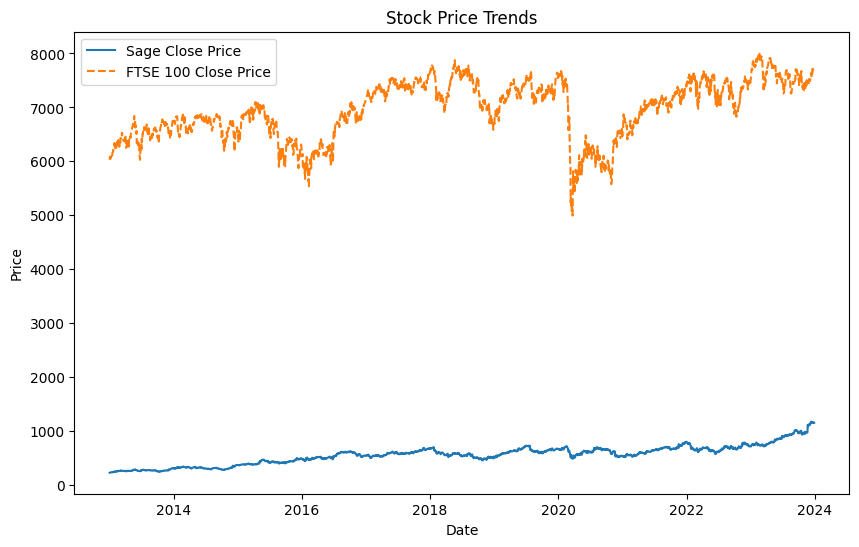

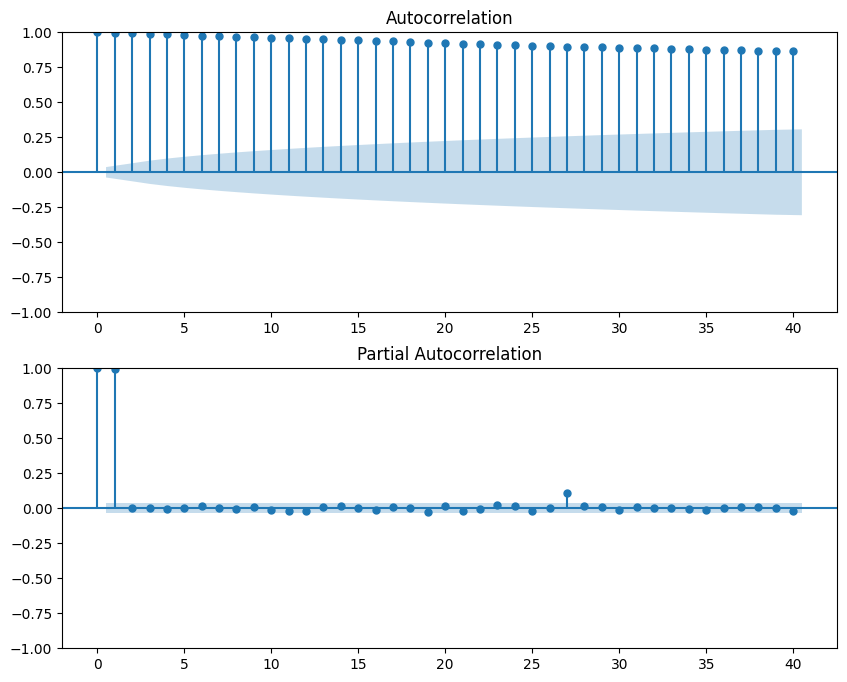

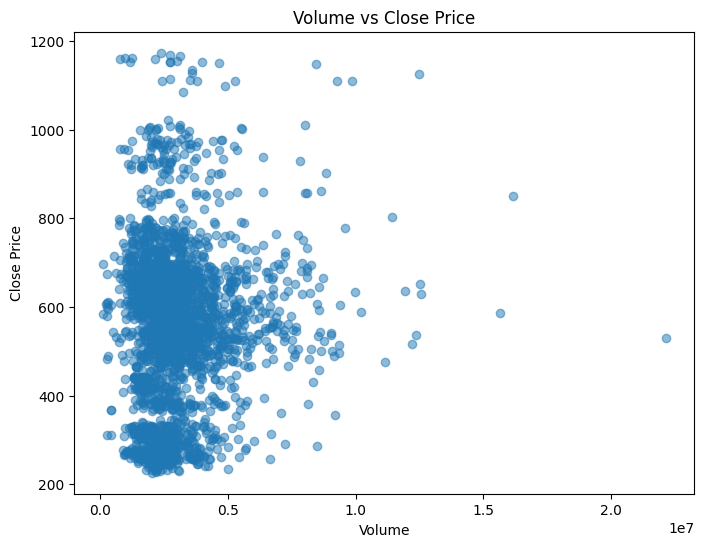

Sample Sentiment Scores:
                                                         Text  Sentiment_MA
Date                                                                       
2013-01-02                    Sage stocks are performing well        0.2732
2013-01-03  There are concerns about market volatility for...        0.0000
2013-01-04      Sage has reported a strong quarterly earnings        0.5106
2013-01-07  Uncertainty around the global economy is risin...       -0.3400
2013-01-08  New innovations from Sage are driving stock gr...        0.3818
NaN values after handling:
Open            1
High            1
Low             1
Close           0
Volume          1
Dividends       1
Stock Splits    1
FTSE_Close      0
Text            0
Sentiment_MA    0
dtype: int64
Train and Test set sizes: 2222 556


/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_2230/4156907896.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tickerDf['FTSE_Close'] = tickerDf['FTSE_Close'].interpolate(method='linear').fillna(method='ffill')
/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_2230/4156907896.py:81: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tickerDf['Close'] = tickerDf['Close'].fillna(method='ffill')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:4

ARIMA Model Performance:
RMSE: 5178883270789861588364238520320.0000
MAE: 4321250254232234572861314957312.0000
MAPE: nan%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_2230/4156907896.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  arima_mape = np.mean(np.abs((test['Close'] - arima_forecast) / test['Close'])) * 100


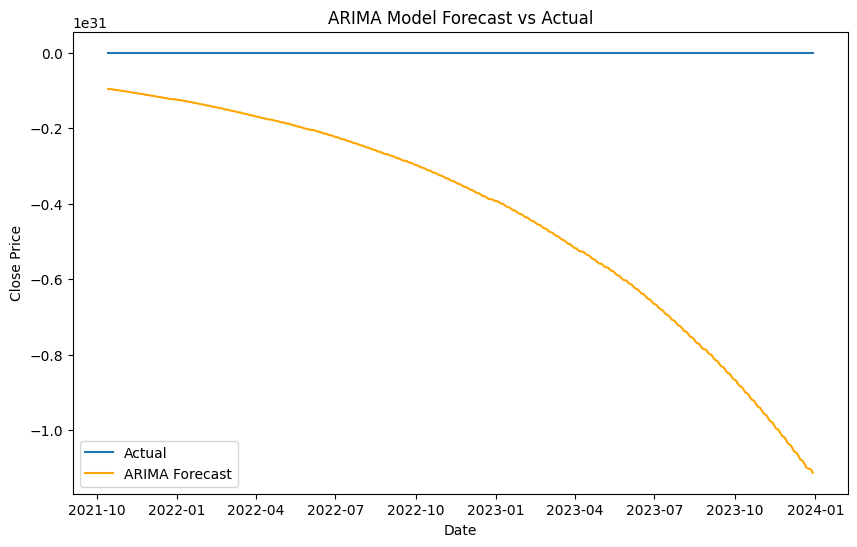

ARIMA Model Directional Classification Metrics:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/var/folders/bc/bbckk6f56l93t9bbs022mvw80000gn/T/ipykernel_2230/4156907896.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Actual_Direction'] = (test['Close'].diff() > 0).astype(int)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm

# Step 1: Fetch and Preprocess Data
tickerSymbol = 'SGE.L'
tickerData = yf.Ticker(tickerSymbol)
tickerDf = tickerData.history(period='1d', start='2013-01-01', end='2024-01-01')

# Fetch FTSE 100 data
ftse_data = yf.download("^FTSE", start="2013-01-01", end="2024-01-01")

# Convert both DateTime indexes to timezone-naive
tickerDf.index = tickerDf.index.tz_localize(None)
ftse_data.index = ftse_data.index.tz_localize(None)

# Merge FTSE data and rename column for clarity
tickerDf = tickerDf.merge(ftse_data[['Close']], how='outer', left_index=True, right_index=True, suffixes=('', '_FTSE'))
tickerDf.rename(columns={'Close_FTSE': 'FTSE_Close'}, inplace=True)

# Step 2: Exploratory Data Analysis (EDA)
# Basic information and feature check
print("Dataset Information and First Few Rows:")
print(tickerDf.info())
print(tickerDf.head())

# Check for missing values
print("Missing Values:")
print(tickerDf.isna().sum())

# Plot stock price trend over time
plt.figure(figsize=(10, 6))
plt.plot(tickerDf['Close'], label='Sage Close Price')
plt.plot(tickerDf['FTSE_Close'], label='FTSE 100 Close Price', linestyle='--')
plt.title('Stock Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 3: ACF and PACF Plots for ARIMA suitability
fig, ax = plt.subplots(2, figsize=(10, 8))
sm.graphics.tsa.plot_acf(tickerDf['Close'].dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(tickerDf['Close'].dropna(), lags=40, ax=ax[1])
plt.show()

# Scatter plot to check relationship between Volume and Close Price
plt.figure(figsize=(8, 6))
plt.scatter(tickerDf['Volume'], tickerDf['Close'], alpha=0.5)
plt.title('Volume vs Close Price')
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.show()

# Step 4: Sentiment Analysis with VADER
analyzer = SentimentIntensityAnalyzer()
text_data = [
    "Sage stocks are performing well",
    "There are concerns about market volatility for Sage PLC",
    "Sage has reported a strong quarterly earnings",
    "Uncertainty around the global economy is rising which is affecting Sage",
    "New innovations from Sage are driving stock growth"
]

# Generate sentiment scores and add to DataFrame
tickerDf['Text'] = (text_data * (len(tickerDf) // len(text_data) + 1))[:len(tickerDf)]
tickerDf['Sentiment_MA'] = tickerDf['Text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Check sample of sentiment scores
print("Sample Sentiment Scores:")
print(tickerDf[['Text', 'Sentiment_MA']].head())

# Step 5: Handle Missing Values
tickerDf['FTSE_Close'] = tickerDf['FTSE_Close'].interpolate(method='linear').fillna(method='ffill')
tickerDf['Close'] = tickerDf['Close'].fillna(method='ffill')

# Confirm no remaining NaN values
print("NaN values after handling:")
print(tickerDf.isna().sum())

# Step 6: Split Data into Train and Test Sets
train_size = int(len(tickerDf) * 0.8)
train = tickerDf.iloc[:train_size]
test = tickerDf.iloc[train_size:]

print("Train and Test set sizes:", len(train), len(test))

# Step 7: Fit ARIMA Model with Sentiment and FTSE Data as Exogenous Variables
if not train.empty and not test.empty:
    # Check for stationarity and fit ARIMA
    arima_model = ARIMA(train['Close'], order=(1, 1, 1), exog=train[['FTSE_Close', 'Sentiment_MA']])
    arima_model_fit = arima_model.fit()

    # Step 8: Make predictions
    arima_forecast = arima_model_fit.forecast(steps=len(test), exog=test[['FTSE_Close', 'Sentiment_MA']])

    # Step 9: Evaluate Model Performance
    if not test['Close'].isna().any() and not pd.isna(arima_forecast).any():
        arima_rmse = np.sqrt(mean_squared_error(test['Close'], arima_forecast))
        arima_mae = mean_absolute_error(test['Close'], arima_forecast)
        arima_mape = np.mean(np.abs((test['Close'] - arima_forecast) / test['Close'])) * 100

        print("ARIMA Model Performance:")
        print(f"RMSE: {arima_rmse:.4f}")
        print(f"MAE: {arima_mae:.4f}")
        print(f"MAPE: {arima_mape:.2f}%")

        # Step 10: Plot Actual vs Forecasted Values
        plt.figure(figsize=(10, 6))
        plt.plot(test.index, test['Close'], label='Actual')
        plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='orange')
        plt.title('ARIMA Model Forecast vs Actual')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()
    else:
        print("Error: NaN values found in forecast or test set.")
else:
    print("Error: Train or Test dataset is empty.")

# Step 11: Classification Metrics for Directional Accuracy
# Create binary labels for actual and forecasted price movements
test['Actual_Direction'] = (test['Close'].diff() > 0).astype(int)
forecasted_direction = (pd.Series(arima_forecast).diff() > 0).astype(int)

# Align lengths and drop first NaN from diff()
test_direction = test['Actual_Direction'].iloc[1:]
forecasted_direction = forecasted_direction[1:]

# Calculate precision, recall, and F1 score
precision = precision_score(test_direction, forecasted_direction)
recall = recall_score(test_direction, forecasted_direction)
f1 = f1_score(test_direction, forecasted_direction)

print("ARIMA Model Directional Classification Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
